In [1]:
import sys
import pandas as pd
sys.path.insert(0, '../Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from clean_velocities import *
# tai from ... import *

In [3]:
%%time

df = database_query("SELECT * FROM SensorData limit 10")
df.head()

CPU times: user 5.82 ms, sys: 492 µs, total: 6.31 ms
Wall time: 12 ms


,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


In [3]:
df = df.sort_values(by=['node_id', 'timestamp'])


### Datan siivous

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 10532
uniques in y 7899
uniques in z 3
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100 400   0]
uniques in q [0]
------------------------------
Number of nodes: 32
------------------------------
Outliers

Data with outliers:  13890906
Ouliers removed:     376791
Data after:  13514115
CPU times: user 3min 4s, sys: 8.31 s, total: 3min 12s
Wall time: 3min 13s


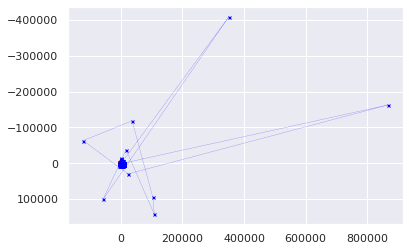

In [4]:
%%time
df = find_outliers(df)
df = clean_dataframe(df)

In [5]:
df

,node_id,timestamp,x,y
0,1,2020-06-24 15:20:08.533,2762,-257
1,1,2020-06-24 15:20:08.620,2870,-344
2,1,2020-06-24 15:20:09.623,2916,-344
3,1,2020-06-24 15:20:09.623,2894,-254
4,1,2020-06-24 15:20:10.116,2888,-188
...,...,...,...,...
11611069,32,2020-05-31 21:59:14.541,593,988
11611070,32,2020-05-31 21:59:28.456,701,668
11611071,32,2020-05-31 21:59:39.968,744,1130
11611072,32,2020-05-31 21:59:46.893,799,204


# EI TOIMI!!!!

In [6]:

# %%time
# df1 = df.copy()
# for i in range(len(df1.node_id.unique())):
#     df1_node = isolation_forest(df1, 0, .003, i+1)
#     print('node numero', i+1, 'valmis')
    
#     if i == 0:
#         df1_node.to_csv('./temp_data.csv', index=False)
#     else:
#         df1_node.to_csv('./temp_data.csv',mode='a', header=False, index=False)
# df1 = pd.read_csv('./temp_data.csv')
# import os
# os.remove("./temp_data.csv") 
# df1.head(5)

### Diskretisoidaan data

In [7]:
%%time
grid_size = 30
df = xy_to_grid(df, df.x, df.y, grid_size)
df

CPU times: user 549 ms, sys: 116 ms, total: 665 ms
Wall time: 664 ms


,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.533,2762,-257,21,9,291
1,1,2020-06-24 15:20:08.620,2870,-344,21,9,291
2,1,2020-06-24 15:20:09.623,2916,-344,21,9,291
3,1,2020-06-24 15:20:09.623,2894,-254,21,9,291
4,1,2020-06-24 15:20:10.116,2888,-188,21,10,321
...,...,...,...,...,...,...,...
11611069,32,2020-05-31 21:59:14.541,593,988,8,16,488
11611070,32,2020-05-31 21:59:28.456,701,668,9,14,429
11611071,32,2020-05-31 21:59:39.968,744,1130,9,17,519
11611072,32,2020-05-31 21:59:46.893,799,204,9,12,369


### Etsitään sisään- ja uloskäynnit. Muokataan ne myös ID-muotoon

In [8]:
%%time
in_x, in_y = sisään(df)
out_x, out_y = ulos(df)

in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# draw_exits(df1, in_x, in_y, out_x, out_y)

CPU times: user 5.72 s, sys: 936 ms, total: 6.66 s
Wall time: 6.65 s


### Erotellaan yksittäiset reitit

In [9]:
%%time
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df = reitit_dataframeksi(reitit)


CPU times: user 1min 10s, sys: 964 ms, total: 1min 11s
Wall time: 1min 11s


In [10]:
df = df[~df["grid_id"].isin(u_in_ID)]
df = df[~df["grid_id"].isin(u_out_ID)]
df = df[df["ajokerta"]!= 8806]
# plot_unique_routes(df, grid_size, in_x, in_y, out_x, out_y)  

In [11]:

df

,ajokerta,node_id,timestamp,x,y,grid_id,Lapimeno
1,1,1,2020-06-24 15:20:12.995,22,11,352,64858.412
2,1,1,2020-06-24 15:20:13.596,22,11,352,64858.412
3,1,1,2020-06-24 15:20:14.482,22,11,352,64858.412
7,1,1,2020-06-24 15:20:21.982,26,12,386,64858.412
8,1,1,2020-06-24 15:20:22.715,25,12,385,64858.412
...,...,...,...,...,...,...,...
1986,8805,31,2020-09-25 13:32:50.038,15,12,375,19909.0
1987,8805,31,2020-09-25 13:32:50.039,15,12,375,19909.0
1988,8805,31,2020-09-25 13:32:50.039,14,12,374,19909.0
1989,8805,31,2020-09-25 13:32:51.038,14,12,374,19909.0


In [12]:
# a = pd.to_datetime(df.loc[df["ajokerta"] == 1].node_id[0])# - df.loc[df["ajokerta"] == 1].node_id[0]
# b = pd.to_datetime(df.loc[df["ajokerta"] == 1].node_id[0])

# df.loc[:, 'start'] = pd.to_datetime(data.loc[:, 'start'])
# df.loc[:, 'stop'] = pd.to_datetime(data.loc[:, 'stop'])

In [4]:
from write_df_to_database import write_df_to_mariadb

In [15]:
write_df_to_mariadb(df, "ASDDB")

Existing table found. Prepairing to Drop Table named ASDDB...


Continue? yes/no:  yes


Done! Prepairing to write dataframe to ASDDB
Writing data 1 / 22
Writing data 2 / 22
Writing data 3 / 22
Writing data 4 / 22
Writing data 5 / 22
Writing data 6 / 22
Writing data 7 / 22
Writing data 8 / 22
Writing data 9 / 22
Writing data 10 / 22
Writing data 11 / 22
Writing data 12 / 22
Writing data 13 / 22
Writing data 14 / 22
Writing data 15 / 22
Writing data 16 / 22
Writing data 17 / 22
Writing data 18 / 22
Writing data 19 / 22
Writing data 20 / 22
Writing data 21 / 22
Writing data 22 / 22
Done!


In [ ]:
plot_unique_routes(df[df["ajokerta"] == 8806], grid_size, in_x, in_y, out_x, out_y)  

In [ ]:
type(df[df["ajokerta"] == 1].timestamp.iloc[-1] - df[df["ajokerta"] == 1].timestamp.iloc[0])


In [33]:
df

,ajokerta,node_id,timestamp,x,y,grid_id,Lapimeno
1,1,1,2020-06-24 15:20:12.995,22,11,352,64858.412
2,1,1,2020-06-24 15:20:13.596,22,11,352,64858.412
3,1,1,2020-06-24 15:20:14.482,22,11,352,64858.412
7,1,1,2020-06-24 15:20:21.982,26,12,386,64858.412
8,1,1,2020-06-24 15:20:22.715,25,12,385,64858.412
...,...,...,...,...,...,...,...
1986,8805,31,2020-09-25 13:32:50.038,15,12,375,19909.0
1987,8805,31,2020-09-25 13:32:50.039,15,12,375,19909.0
1988,8805,31,2020-09-25 13:32:50.039,14,12,374,19909.0
1989,8805,31,2020-09-25 13:32:51.038,14,12,374,19909.0
